In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import sys
from PIL import Image
import time

# indroot = '/media/senseable-beast/beast-brain-1/Data/streetviewdata/ind/'
# imgroot = '/media/senseable-beast/beast-brain-1/Data/streetviewdata/img2/'
# tgtroot = '/media/senseable-beast/beast-brain-1/Data/streetviewdata/img/'
indroot = 'C:/Users/lezhi/Dropbox/thesis/indfake/'
imgroot = 'C:/Users/lezhi/Dropbox/thesis/img2/'
tgtroot = 'C:/Users/lezhi/Dropbox/thesis/img/'

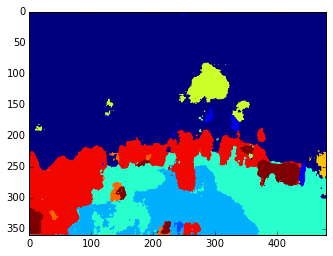

In [3]:
image = Image.open(tgtroot+'hongkong/22.278656,114.180662977_0.png') 
#  42.300131,-71.10339107_3  22.259156,114.200118326_1.png  22.266656,114.187148093_2.png  22.277156,114.170935302_1.png
# 22.278656,114.180662977_2  22.278656,114.166071465_0  22.278656,114.180662977_0

imarr = np.array(image)
alpha = imarr[:, :, 3]
plt.imshow(alpha)

In [4]:
imarr.shape

(360L, 480L, 4L)

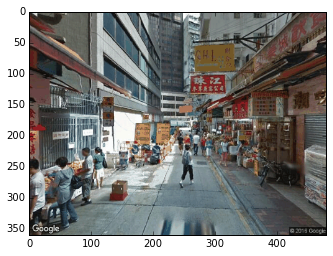

In [5]:
image = Image.fromarray(imarr[:,:,:3], 'RGB')
result = image.convert('P', palette=Image.ADAPTIVE, colors=256)
plt.imshow(result)

In [6]:
set(alpha.reshape(alpha.shape[0]*alpha.shape[1]))

{244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254}

In [7]:
labels = ["Sky", "Building", "Pole", "Unlabelled", "Road", \
        "Pavement", "Tree", "SignSymbol", "Fence", \
        "Car", "Pedestrian", "Bicyclist"]

# def getmask(a, **kwargs):
#     inds = [labels.index(c)+243 for c in kwargs['category']]    
#     return [(ele in inds) for ele in np.nditer(a)]

# much better performance than the commented method...:
'''input a 2D index matrix, return a 2D boolean matrix 
where True means the pixel belongs to one of the specified "category".'''

def getmask(a, **kwargs):
    inds = [labels.index(c)+243 for c in kwargs['category']] 
    print np.array(inds)-243
    indicators = np.zeros((a.shape[0], a.shape[1], len(inds))).astype(np.uint8)
    for i in range(len(inds)):
        indicators[:,:,i] = np.array(np.squeeze([a==inds[i]]))
    return np.any(indicators, axis=2)

getmask(imarr[:,:,3], category=["Sky", "Building"]).shape

[0 1]


(360L, 480L)

In [8]:
mask = getmask(imarr[:,:,3], category=["Sky", "Building"])

[0 1]


[1 7 2]


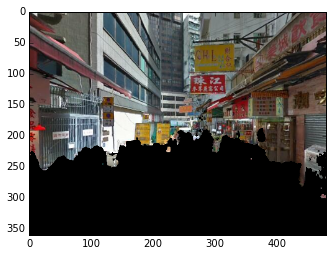

In [9]:
#["Bicyclist","Pedestrian", "Road", "Pavement","Car"]
# ["Building", "SignSymbol", "Pole"]
# ["Sky"]
# ["Tree"]
# ["SignSymbol"]

mask = getmask(imarr[:,:,3], category=["Building", "SignSymbol", "Pole"])
base = (0*np.ones((360,480,3))).astype(np.uint8)
base[mask] = (imarr[:,:,:3])[mask]
color_array = (imarr[:,:,:3])[mask]
plt.imshow(base)

In [31]:
import colorsys
colorsys.rgb_to_hls((4.27863777e-01,3.40557276e-01,2.94840041e-01))

TypeError: rgb_to_hls() takes exactly 3 arguments (1 given)

kmeans.cluster_centers_: [[  4.11128776e-01   4.16534181e-01   3.90990991e-01]
 [  2.85204991e-04   1.52788388e-04   1.93531958e-04]
 [  5.92810458e-01   6.11204482e-01   6.10457516e-01]
 [  1.05882353e-01   9.95230525e-02   8.27768945e-02]
 [  3.81996435e-01   1.36898396e-01   1.05882353e-01]
 [  9.41637832e-01   9.48327566e-01   9.46482122e-01]
 [  4.20975832e-01   3.37984496e-01   2.91928865e-01]
 [  7.49019608e-01   7.58300654e-01   7.56209150e-01]
 [  3.02202112e-01   2.45610860e-01   2.11523379e-01]
 [  6.83333333e-01   5.05882353e-01   2.59803922e-01]
 [  4.84396576e-01   5.03673019e-01   5.00745650e-01]
 [  2.72293265e-01   3.97271952e-01   4.44330776e-01]
 [  1.97478992e-01   1.58823529e-01   1.22315593e-01]
 [  1.81274510e-01   2.10686275e-01   2.13529412e-01]
 [  4.56470588e-01   3.67058824e-01   8.54901961e-02]
 [  2.80332739e-01   3.13131313e-01   3.26381462e-01]
 [  4.35450980e-01   2.31843137e-01   2.37019608e-01]]
X: [[  2.01936376e-01   4.03762586e-01   3.16314477e-02]

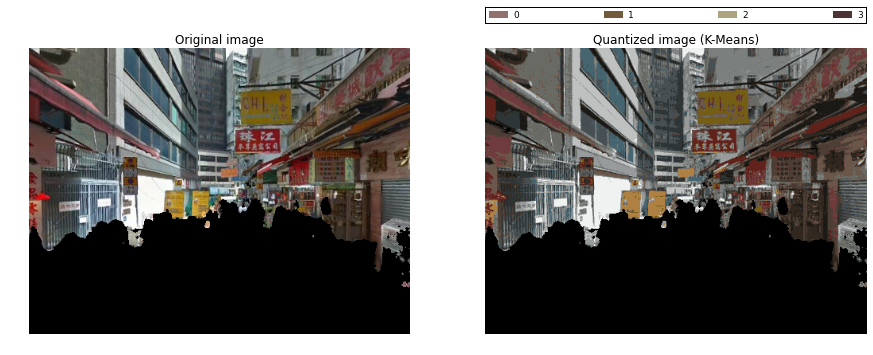

In [118]:
# http://scikit-learn.org/stable/auto_examples/cluster/plot_color_quantization.html

from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle

n_colors = 17

image = Image.fromarray(base, 'RGB')
# Dividing by 255 because plt.imshow need to be in the range [0-1]
image = np.array(image, dtype=np.float64) / 255

# transform to a 2D numpy array.
w, h, d = original_shape = tuple(image.shape)
assert d == 3
image_array = np.reshape(image, (w * h, d))
image_array_sample = shuffle(image_array, random_state=0)[:1000]
kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)

####################### Get labels for all points
labels = kmeans.predict(image_array)
#print "most frequent color:", kmeans.cluster_centers_[max([np.sum(labels == i) for i in range(len(kmeans.cluster_centers_))])]
# print max([np.sum(labels == i) for i in range(len(kmeans.cluster_centers_))])
print "kmeans.cluster_centers_:", kmeans.cluster_centers_

##################### Compute clustering with MeanShift
#X = np.array([list(colorsys.rgb_to_hls(c[0], c[1], c[2])) for c in kmeans.cluster_centers_ if (c[0]>0.01 and c[1]>0.01 and c[2]>0.01)])
X = np.array([list(colorsys.rgb_to_hls(c[0], c[1], c[2])) for c in kmeans.cluster_centers_])
X_s = np.array([i for i in X if i[2]>0.3 and i[1]>0.1])
print "X:", X
print "X_s:", X_s

def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

import matplotlib.patches as mpatches

# Display all results, alongside original image
plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.axis('off')
plt.title('Original image')
plt.imshow(image)

plt.subplot(122)
plt.axis('off')
plt.title('Quantized image (K-Means)')
# new_cookbook = np.array([cluster_centers[i] for i in ms_labels])
new_cookbook = kmeans.cluster_centers_
plt.imshow(recreate_image(new_cookbook, labels, w, h))

handles = []
labels = []
def hex_to_rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))
def rgb_to_hex(rgb):
    rgb_ = tuple(((np.array(rgb)*255).astype(np.uint8)))    
    return '#%02x%02x%02x' % rgb_

for i in range(len(X_s)):
    hexi = rgb_to_hex(tuple(colorsys.hsv_to_rgb(X_s[i][0], X_s[i][1], X_s[i][2])))
    rect = mpatches.Patch(color=hexi)
    handles.append(rect)
    labels.append(str(i))
plt.legend(handles,labels,bbox_to_anchor=(0. ,1.09 ,1.,0.3),loc=8,
           ncol=5,mode='expand',borderaxespad=0,prop={'size':9},numpoints=1)

kmeans.cluster_centers_: [[  4.53411765e-01   4.64235294e-01   4.58117647e-01]
 [  4.47018186e-04   2.53987605e-04   3.04785126e-04]
 [  1.73714891e-01   2.03285639e-01   2.05299417e-01]
 [  7.39668175e-01   7.77677225e-01   7.71493213e-01]
 [  2.82426933e-01   3.20014798e-01   3.37772845e-01]
 [  2.04248366e-01   1.58823529e-01   1.17864924e-01]
 [  3.98910675e-01   2.50435730e-01   2.42047930e-01]
 [  9.41637832e-01   9.48327566e-01   9.46482122e-01]
 [  4.27863777e-01   3.40557276e-01   2.94840041e-01]
 [  5.76597090e-01   5.98481973e-01   5.98734978e-01]
 [  2.60784314e-01   3.92745098e-01   4.39411765e-01]
 [  2.72924489e-01   2.65665415e-01   2.49478515e-01]
 [  4.50980392e-01   3.66488414e-01   9.48306595e-02]
 [  6.91316527e-01   5.22128852e-01   2.41456583e-01]
 [  1.09401709e-01   1.03871292e-01   8.79839115e-02]
 [  3.16239316e-01   2.07139266e-01   1.59477124e-01]
 [  4.45424837e-01   1.03267974e-01   1.00980392e-01]
 [  4.04364326e-01   4.06894371e-01   3.81846932e-01]
 [ 

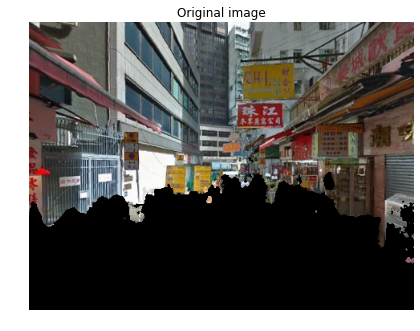

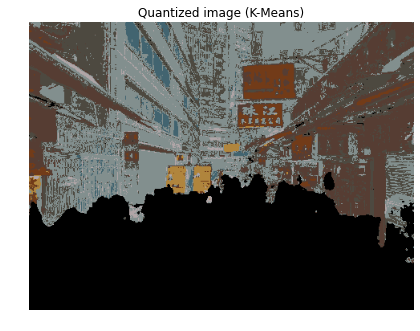

In [65]:
# http://scikit-learn.org/stable/auto_examples/cluster/plot_color_quantization.html

from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle

n_colors = 20

image = Image.fromarray(base, 'RGB')
# Dividing by 255 because plt.imshow need to be in the range [0-1]
image = np.array(image, dtype=np.float64) / 255

# transform to a 2D numpy array.
w, h, d = original_shape = tuple(image.shape)
assert d == 3
image_array = np.reshape(image, (w * h, d))
image_array_sample = shuffle(image_array, random_state=0)[:1000]
kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)

####################### Get labels for all points
labels = kmeans.predict(image_array)
#print "most frequent color:", kmeans.cluster_centers_[max([np.sum(labels == i) for i in range(len(kmeans.cluster_centers_))])]
# print max([np.sum(labels == i) for i in range(len(kmeans.cluster_centers_))])
print "kmeans.cluster_centers_:", kmeans.cluster_centers_

##################### Compute clustering with MeanShift
weight = 100

def construct_hsv(c):
    hsv_lst = list(colorsys.rgb_to_hls(c[0], c[1], c[2]))
    return [weight*hsv_lst[0], hsv_lst[1], weight*hsv_lst[2]]

def de_construct_hsv(c):
    return list(colorsys.hls_to_rgb(c[0]/weight, c[1], c[2]/weight))

X = np.array([construct_hsv(c) for c in kmeans.cluster_centers_])
# print "X:", X

# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(X, quantile=0.18)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
ms_labels = ms.labels_
cluster_centers = np.array([de_construct_hsv(c) for c in ms.cluster_centers_])
print "ms_labels:", ms_labels
print "cluster_centers:", cluster_centers

labels_unique = np.unique(ms_labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

# Display all results, alongside original image
plt.figure(1)
plt.clf()
ax = plt.axes([0, 0, 1, 1])
plt.axis('off')
plt.title('Original image')
plt.imshow(image)

plt.figure(2)
plt.clf()
ax = plt.axes([0, 0, 1, 1])
plt.axis('off')
plt.title('Quantized image (K-Means)')
new_cookbook = np.array([cluster_centers[i] for i in ms_labels])
#new_cookbook = kmeans.cluster_centers_
plt.imshow(recreate_image(new_cookbook, labels, w, h))
